# CH.10 Deep learning for timeseries

Chapter contents:
* 시계열(timeseries) 데이터와 관련된 기계 학습 작업의 예
* 순환 신경망(RNN) 이해
* 온도-예측 예제에 RNN 적용
* 고급 RNN 사용 패턴

## Different kinds of timeseries tasks

시계열(Timeseries): 일정한 간격으로 측정을 통해 얻은 모든 데이터

Examples : 
* 주식의 일일 가격
* 도시의 시간당 전력 소비
* 상점의 주간 판매

이전 유형의 데이터와 달리 다음과 같은 이해가 필요합니다.
* 시스템의 역학
* 반복적인 주기(cycles) (시간 경과에 따른 추세, 규칙적인 체제, 갑작스러운 스파이크 등)

가장 일반적인 작업: **예측(forcasting)** (시리즈에서 다음에 일어날 일 예측)

기타 작업:

* **분류**
  * e.g. 웹사이트에서 방문자의 활동을 기반으로 한 봇 vs. 인간
* **이벤트 감지**
  * e.g. 핫워드(hotword) 감지("OK Google", "Hey Alexa")
* **이상 감지**
  * e.g. 기업 네트워크에서의 비정상적인 활동(공격 가능성)
  * 일반적으로 비지도 학습을 통해 수행

## A temperature-forecasting example

타겟(target)
* 24시간 후의 온도 예측

데이터
* 대기압, 습도, 풍향 등 14개의 시간당 측정 시계열(기상 시계열 데이터 세트)

우리가 할 일들
* 조밀하게 연결된 네트워크(Densely connected networks: FC)
* 컨볼루션 네트워크(Convolutional networks: CNN)
* 순환 신경망(Recurrent neural networks: RNN)

In [5]:
#!curl https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
# Use browser instead.... then unzip as follows
!unzip jena_climate_2009_2016.csv.zip

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


**Inspecting the data of the Jena weather dataset**

In [12]:
import os
fname = os.path.join("jena_climate_2009_2016.csv")

with open(fname) as f:
    data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header, f'==> Date Time + {len(header)-1} features')
print(f'No. of samples : {len(lines)}')

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"'] ==> Date Time + 14 features
No. of samples : 420451


**Parsing the data**

* "Date Time" 열(column) 제거
* 열(column)당 하나의 numpy 배열 생성
* 별도의 temperature 열(column)(타겟이기도 하므로)

In [14]:
import numpy as np
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]  # choose 14 features
    temperature[i] = values[1]   # 2-nd in the 14 features
    raw_data[i, :] = values[:]

**Plotting the temperature timeseries**

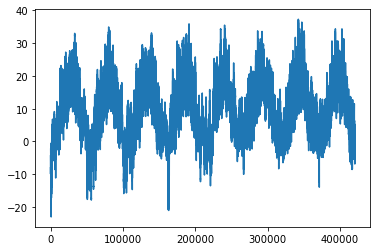

In [15]:
from matplotlib import pyplot as plt
plt.plot(range(len(temperature)), temperature)

<img src="https://drek4537l1klr.cloudfront.net/chollet2/Figures/10-01.png" width="300"><p style="text-align:center">Figure 10.1 Temperature over the full temporal range of the dataset (ºC)</p>

**Plotting the first 10 days of the temperature timeseries**

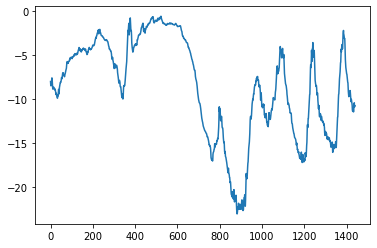

In [16]:
plt.plot(range(1440), temperature[:1440])  # 10x24x6

<img src="https://drek4537l1klr.cloudfront.net/chollet2/Figures/10-02.png" width="300"><p style="text-align:center">Figure 10.2 Temperature over the first 10 days of the dataset (ºC)</p>

**Computing the number of samples we'll use for each data split**

* first 50% training
* following 25% validation
* last 25% testing

중요: **테스트 데이터는 훈련 데이터보다 최신것이어야 합니다.**

(과거가 아닌 미래를 예측하려고 노력합니다)

In [17]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples   = int(0.25 * len(raw_data))
num_test_samples  = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


### Preparing the data

**작업**: 지난 5일 동안의 데이터가 주어지고, 시간당 한 번씩 샘플링되면, 24시간 후의 온도를 예측할 수 있습니까?

**데이터**: 네트워크에는 숫자가 필요합니다. 우리는 이미 float 형식의 데이터를 가지고 있습니다. 벡터화가 필요 없음

**척도(Scale)**: 문제 있음, 일부 값은 수천, 일부는 0 또는 10 주변의 값을 가집니다.

**정규화(normalization)** 필요

**Normalizing the data**

In [19]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

**Dataset object**

다음을 갖는 객체 생성
* 지난 5일 동안의 데이터 배치
* 24시간 후의 목표 온도(target temperature)와 함께

모든 샘플을 메모리에 보관할 필요가 없습니다. 즉석에서 생성할 수 있습니다.

Keras utility `timeseries_dataset_from_array()` 를 사용할 수 있습니다.

In [25]:
import numpy as np
from tensorflow import keras
int_sequence = np.arange(10)
dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-3],
    targets=int_sequence[3:],
    sequence_length=3,
    batch_size=2,
)

for inputs, targets in dummy_dataset:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


**Instantiating datasets for training, validation, and testing**


In [27]:
sampling_rate = 6        # one sample per hour
sequence_length = 120    # 5 days = 5 x 24
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

**Inspecting the output of one of our datasets**

In [28]:
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (256, 120, 14)
targets shape: (256,)


### A common-sense, non-machine-learning baseline

상식적인 단순한 기준선을 마음에 두는 것이 항상 좋습니다.

예를 들어, 온도 예측 단순 알고리즘으로 => 마지막으로 알려진 온도 반환 (1일 전, 같은 시간)

**Computing the common-sense baseline MAE**

In [31]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]    # canceling the normalization for Temp.
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 2.44
Test MAE: 2.62


### Let's try a basic machine-learning model

**Training and evaluating a densely connected model**

In [32]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_dense.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 11s 9ms/step - loss: 11.8382 - mae: 2.6687 - val_loss: 10.2920 - val_mae: 2.5396
Epoch 2/10
819/819 [==============================] - 8s 10ms/step - loss: 8.9512 - mae: 2.3541 - val_loss: 10.8945 - val_mae: 2.6043
Epoch 3/10
819/819 [==============================] - 8s 9ms/step - loss: 8.2316 - mae: 2.2575 - val_loss: 10.3351 - val_mae: 2.5482
Epoch 4/10
819/819 [==============================] - 7s 9ms/step - loss: 7.7945 - mae: 2.1944 - val_loss: 10.0473 - val_mae: 2.5112
Epoch 5/10
819/819 [==============================] - 8s 10ms/step - loss: 7.5057 - mae: 2.1541 - val_loss: 12.1837 - val_mae: 2.7677
Epoch 6/10
819/819 [==============================] - 8s 9ms/step - loss: 7.2591 - mae: 2.1183 - val_loss: 11.9837 - val_mae: 2.7602
Epoch 7/10
819/819 [==============================] - 7s 9ms/step - loss: 7.0325 - mae: 2.0864 - val_loss: 12.1183 - val_mae: 2.7495
Epoch 8/10
819/819 [==============================] - 8s 9ms/step

| Strategy      |  TestMAE |
|---------------|:--------:|
| jena_baseline |   2.62   |
| jena_dense    |   2.58   |

**Plotting results**

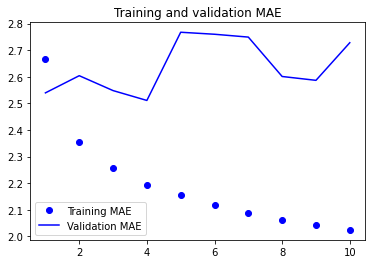

In [33]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

<img src="https://drek4537l1klr.cloudfront.net/chollet2/Figures/10-03.png" width="300"><p style="text-align:center">Figure 10.3 Training and validation MAE on the Jena temperature-forecasting task with a simple, densely connected network</p>

### Let's try a 1D convolutional model

In [34]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_conv.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 26s 14ms/step - loss: 22.1314 - mae: 3.6945 - val_loss: 15.8323 - val_mae: 3.1494
Epoch 2/10
819/819 [==============================] - 11s 14ms/step - loss: 15.4959 - mae: 3.1364 - val_loss: 14.7954 - val_mae: 3.0548
Epoch 3/10
819/819 [==============================] - 11s 14ms/step - loss: 14.2262 - mae: 2.9985 - val_loss: 19.7321 - val_mae: 3.5451
Epoch 4/10
819/819 [==============================] - 11s 14ms/step - loss: 13.3181 - mae: 2.8984 - val_loss: 15.5239 - val_mae: 3.1039
Epoch 5/10
819/819 [==============================] - 12s 15ms/step - loss: 12.6164 - mae: 2.8191 - val_loss: 14.8619 - val_mae: 3.0412
Epoch 6/10
819/819 [==============================] - 11s 14ms/step - loss: 12.0080 - mae: 2.7480 - val_loss: 14.4884 - val_mae: 2.9898
Epoch 7/10
819/819 [==============================] - 12s 14ms/step - loss: 11.4894 - mae: 2.6860 - val_loss: 15.9889 - val_mae: 3.1539
Epoch 8/10
819/819 [============================

| Strategy      |  TestMAE |
|---------------|:--------:|
| jena_baseline |   2.62   |
| jena_dense    |   2.58   |
| jena_conv     |   3.09   |

왜 결과가 더 나쁜가?

* 날씨 데이터는 이동 불변성(translation invariance) 가정을 존중하지 않습니다.
* 우리 데이터 순서가 중요함. 최근 과거는 5일 전의 데이터보다 다음 날의 기온을 예측하는 데 훨씬 더 많은 정보를 제공합니다. 1D convnet은 이 사실을 활용할 수 없습니다.

### A first recurrent baseline

**A simple LSTM-based model**

In [35]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 20s 14ms/step - loss: 39.0683 - mae: 4.5416 - val_loss: 11.6355 - val_mae: 2.5903
Epoch 2/10
819/819 [==============================] - 11s 14ms/step - loss: 10.5745 - mae: 2.5233 - val_loss: 9.2902 - val_mae: 2.3749
Epoch 3/10
819/819 [==============================] - 11s 13ms/step - loss: 9.3642 - mae: 2.3865 - val_loss: 9.4807 - val_mae: 2.4145
Epoch 4/10
819/819 [==============================] - 11s 14ms/step - loss: 8.9379 - mae: 2.3293 - val_loss: 9.2746 - val_mae: 2.3872
Epoch 5/10
819/819 [==============================] - 11s 13ms/step - loss: 8.6083 - mae: 2.2854 - val_loss: 9.5261 - val_mae: 2.4218
Epoch 6/10
819/819 [==============================] - 11s 13ms/step - loss: 8.3456 - mae: 2.2502 - val_loss: 9.5629 - val_mae: 2.4184
Epoch 7/10
819/819 [==============================] - 11s 13ms/step - loss: 8.0091 - mae: 2.2003 - val_loss: 10.1357 - val_mae: 2.4931
Epoch 8/10
819/819 [==============================] - 11s 

| Strategy      |  TestMAE |
|---------------|:--------:|
| jena_baseline |   2.62   |
| jena_dense    |   2.58   |
| jena_conv     |   3.09   |
| jena_lstm     |   **2.52**   |

## Understanding recurrent neural networks

완전 연결된(fully connected) 네트워크와 convnet에는 메모리가 없습니다. 그들에게 주어지는 각 입력은 독립적으로 처리됩니다. 따라서 시퀀스를 단일 데이터 포인트로 바꿉니다(예: Flatten it). 이를 피드포워드(feedforward) 네트워크라고 합니다.

우리가 원하는 것은 정보를 점진적으로 처리하고, 내부 모델을 유지하며, 업데이트하는 것입니다.

RNN에서

* 데이터 포인트는 단일 단계로 처리되지 않습니다.
* 네트워크는 시퀀스 요소를 내부적으로 반복합니다.
* 현재 상태를 유지 및 업데이트하고, 이를 시퀀스의 다음 입력과 함께 공급합니다.


<img src="https://drek4537l1klr.cloudfront.net/chollet2/Figures/10-06.png" width="150"><p style="text-align:center">Figure 10.6 A recurrent network: a network with a loop</p>

**NumPy implementation of a simple RNN**

In [36]:
import numpy as np
timesteps = 100
input_features = 32
output_features = 64
inputs = np.random.random((timesteps, input_features))
state_t = np.zeros((output_features,))
W = np.random.random((output_features, input_features))
U = np.random.random((output_features, output_features))
b = np.random.random((output_features,))
successive_outputs = []
for input_t in inputs:
    output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)  # tanh(W input + U state + b)
    successive_outputs.append(output_t)
    state_t = output_t
final_output_sequence = np.stack(successive_outputs, axis=0)

### A recurrent layer in Keras

**An RNN layer that can process sequences of any length**

In [38]:
num_features = 14
inputs = keras.Input(shape=(None, num_features))   # inputs[time_step, num_features]
outputs = layers.SimpleRNN(16)(inputs)

**An RNN layer that returns only its last output step**

순환 레이어에 대한 두 가지 모드:

* 각 시간 단계에 대한 연속 **출력의 전체 시퀀스를 반환**합니다.
* 각 입력 시퀀스의 **마지막 출력만 반환**

<img src="https://miro.medium.com/max/892/0*meStrcl0-hSG2-lC.PNG" width="400"><p style="text-align:center">Left: 마지막 출력만 반환, Right: 전체 시퀀스를 반환</p>



In [40]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=False)(inputs)
print(outputs.shape)

(None, 16)


**An RNN layer that returns its full output sequence**

In [41]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=True)(inputs)
print(outputs.shape)

(None, 120, 16)


**Stacking RNN layers**

네트워크의 표현력(representational power)을 높이는 데 좋습니다.

모든 중간 계층은 전체 출력 시퀀스를 반환해야 합니다.

In [42]:
inputs = keras.Input(shape=(steps, num_features))
x = layers.SimpleRNN(16, return_sequences=True)(inputs)
x = layers.SimpleRNN(16, return_sequences=True)(x)
outputs = layers.SimpleRNN(16)(x)

`SimpleRNN`은 그라디언트 소멸 문제로 인해 그다지 좋지 않습니다(매우 깊은 비순환 네트워크와 유사).

솔루션: `LSTM` 또는 `GRU`

`residual connections`과 유사하지만 `carry` 변수 사용(시간 단계에 걸쳐 정보 전달)

```
y = activation(dot(state_t, U) + dot(input_t, W) + b)
```
**SimpleRNN**

<img src="https://drek4537l1klr.cloudfront.net/chollet2/Figures/10-07.png" width="500"><p style="text-align:center">Figure 10.7 A simple RNN, unrolled over time</p>


**SimpleRNN to LSTM: add a carry track**

<img src="https://drek4537l1klr.cloudfront.net/chollet2/Figures/10-09.png" width="500"><p style="text-align:center">Figure 10.9 Going from a SimpleRNN to an LSTM: adding a carry track</p>

```
output_t = activation(dot(state_t, Uo) + dot(input_t, Wo) + dot(c_t, Vo) + bo)
i_t = activation(dot(state_t, Ui) + dot(input_t, Wi)  + bi)
f_t = activation(dot(state_t, Uf) + dot(input_t, Wf)  + bf)
k_t = activation(dot(state_t, Uk) + dot(input_t, Wk)  + bk)
c_t+1 = i_t * k_t + c_t * f_t
```

**LSTM**


<img src="https://drek4537l1klr.cloudfront.net/chollet2/Figures/10-10.png" width="500"><p style="text-align:center">Figure 10.10 Anatomy of an LSTM</p>

LSTM 셀의 특정 아키텍처에 대해 아무것도 이해할 필요가 없습니다.

인간으로서 그것을 이해하는 것이 당신의 일이 되어서는 안 됩니다.

LSTM 호출이 무엇을 의미하는지 염두에 두십시오. 과거 정보가 나중에 다시 주입되도록 하여 vanishing-gradient 문제를 해결합니다.

## Advanced use of recurrent neural networks

We'll see:
* Recurrent dropout
* Stacking recurrent layers
* Bidirectional recurrent layers

### Using recurrent dropout to fight overfitting

**Training and evaluating a dropout-regularized LSTM**

In [44]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
#x = layers.LSTM(32, recurrent_dropout=0.25)(inputs)  # caution: too slow for 'cpu' 
x = layers.LSTM(32)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/50
819/819 [==============================] - 13s 14ms/step - loss: 28.6152 - mae: 3.9338 - val_loss: 9.8976 - val_mae: 2.4300
Epoch 2/50
819/819 [==============================] - 11s 14ms/step - loss: 14.5545 - mae: 2.9594 - val_loss: 9.5590 - val_mae: 2.3895
Epoch 3/50
819/819 [==============================] - 11s 13ms/step - loss: 13.7693 - mae: 2.8738 - val_loss: 9.6138 - val_mae: 2.4073
Epoch 4/50
819/819 [==============================] - 11s 14ms/step - loss: 13.1801 - mae: 2.8091 - val_loss: 9.2852 - val_mae: 2.3754
Epoch 5/50
819/819 [==============================] - 11s 14ms/step - loss: 12.7164 - mae: 2.7576 - val_loss: 8.9330 - val_mae: 2.3276
Epoch 6/50
819/819 [==============================] - 11s 14ms/step - loss: 12.2105 - mae: 2.7052 - val_loss: 9.2308 - val_mae: 2.3643
Epoch 7/50
819/819 [==============================] - 11s 13ms/step - loss: 11.7952 - mae: 2.6606 - val_loss: 8.9133 - val_mae: 2.3165
Epoch 8/50
819/819 [==============================] - 1

| Strategy      |  TestMAE |
|---------------|:--------:|
| jena_baseline |   2.62   |
| jena_dense    |   2.58   |
| jena_conv     |   3.09   |
| jena_lstm     |   2.52   |
| jena_lstm_dropout | 2.5* |

처음 20개의 에포크 동안 더 이상 과적합되지 않음

최저 2.27도의 검증 MAE(무학습 기준선에 비해 7% 개선)

2.54도의 테스트 MAE(기준 대비 6% 개선)

<img src="https://drek4537l1klr.cloudfront.net/chollet2/Figures/10-11.png" width="300"><p style="text-align:center">Figure 10.11 Training and validation loss on the Jena temperature-forecasting task with a dropout-regularized LSTM
</p>


In [0]:
inputs = keras.Input(shape=(sequence_length, num_features))
x = layers.LSTM(32, recurrent_dropout=0.2, unroll=True)(inputs)

### Stacking recurrent layers

**Training and evaluating a dropout-regularized, stacked GRU model**

In [45]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
#x = layers.GRU(32, recurrent_dropout=0.5, return_sequences=True)(inputs)
#x = layers.GRU(32, recurrent_dropout=0.5)(x)
x = layers.GRU(32, return_sequences=True)(inputs)
x = layers.GRU(32)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_gru_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_stacked_gru_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/50
819/819 [==============================] - 18s 19ms/step - loss: 23.7150 - mae: 3.6038 - val_loss: 9.1212 - val_mae: 2.3360
Epoch 2/50
819/819 [==============================] - 15s 18ms/step - loss: 13.7843 - mae: 2.8722 - val_loss: 9.1502 - val_mae: 2.3467
Epoch 3/50
819/819 [==============================] - 15s 18ms/step - loss: 12.7639 - mae: 2.7693 - val_loss: 10.2270 - val_mae: 2.5162
Epoch 4/50
819/819 [==============================] - 15s 18ms/step - loss: 11.9569 - mae: 2.6805 - val_loss: 8.8554 - val_mae: 2.3193
Epoch 5/50
819/819 [==============================] - 15s 18ms/step - loss: 11.2158 - mae: 2.5991 - val_loss: 9.1792 - val_mae: 2.3610
Epoch 6/50
819/819 [==============================] - 15s 18ms/step - loss: 10.5787 - mae: 2.5234 - val_loss: 9.3132 - val_mae: 2.3727
Epoch 7/50
819/819 [==============================] - 15s 18ms/step - loss: 10.0392 - mae: 2.4568 - val_loss: 9.8208 - val_mae: 2.4449
Epoch 8/50
819/819 [==============================] - 

| Strategy      |  TestMAE |
|---------------|:--------:|
| jena_baseline |   2.62   |
| jena_dense    |   2.58   |
| jena_conv     |   3.09   |
| jena_lstm     |   2.52   |
| jena_lstm_dropout | 2.5? |
| jena_gru_dropout | 2.45  |

<img src="https://drek4537l1klr.cloudfront.net/chollet2/Figures/10-12.png" width="300"><p style="text-align:center">Figure 10.12 Training and validation loss on the Jena temperature-forecasting task with a stacked GRU network</p>

### Using bidirectional RNNs

양방향 RNN : 일반적인 RNN 변형

NLP에서 자주 사용

입력 시퀀스를 한 방향(시간순 및 역시간순)으로 처리하는 두 개의 일반 RNN을 사용한 다음 해당 표현을 병합합니다.

단방향 RNN에서 간과할 수 있는 패턴을 포착할 수 있습니다.


<img src="https://drek4537l1klr.cloudfront.net/chollet2/Figures/10-14.png" width="300"><p style="text-align:center">Figure 10.14 How a bidirectional RNN layer works
</p>

**Training and evaluating a bidirectional LSTM**

In [47]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(16))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_bidirectional_lstm.keras",
                                    save_best_only=True)
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_bidirectional_lstm.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 18s 19ms/step - loss: 24.4358 - mae: 3.5822 - val_loss: 10.7889 - val_mae: 2.5488
Epoch 2/10
819/819 [==============================] - 15s 18ms/step - loss: 9.6219 - mae: 2.4252 - val_loss: 9.7853 - val_mae: 2.4100
Epoch 3/10
819/819 [==============================] - 15s 19ms/step - loss: 8.6931 - mae: 2.2974 - val_loss: 10.0572 - val_mae: 2.4404
Epoch 4/10
819/819 [==============================] - 15s 18ms/step - loss: 8.0150 - mae: 2.2063 - val_loss: 10.2591 - val_mae: 2.4621
Epoch 5/10
819/819 [==============================] - 15s 19ms/step - loss: 7.5445 - mae: 2.1442 - val_loss: 10.4234 - val_mae: 2.4852
Epoch 6/10
819/819 [==============================] - 15s 18ms/step - loss: 7.2070 - mae: 2.0955 - val_loss: 10.6485 - val_mae: 2.5115
Epoch 7/10
819/819 [==============================] - 15s 18ms/step - loss: 6.9288 - mae: 2.0548 - val_loss: 11.5947 - val_mae: 2.6018
Epoch 8/10
819/819 [==============================] - 1

| Strategy      |  TestMAE |
|---------------|:--------:|
| jena_baseline |   2.62   |
| jena_dense    |   2.58   |
| jena_conv     |   3.09   |
| jena_lstm     |   2.52   |
| jena_lstm_dropout | 2.5? |
| jena_gru_dropout | 2.45 |
| jena_bidirectional_lstm | 2.60 |

일반 LSTM 만큼 성능이 좋지 않음

이 경우에는, 최근 과거가 먼 과거보다 훨씬 더 중요합니다. 

모든 예측 커패서티(capacity)은 네트워크의 시간적 절반에서 만 가져와야 합니다.

### Going even further

* 각 순환 레이어의 노드 수(및 드롭아웃 양) 조정
* RMSprop 옵티마이저에서 사용하는 학습률을 조정하거나 다른 옵티마이저를 사용해 보십시오.
* 단일 Dense 레이어 대신 Dense 레이어 스택을 반복 레이어 상단의 회귀자(regressor)로 사용하십시오.
* 모델에 대한 입력 개선: 더 길거나 짧은 시퀀스 또는 다른 샘플링 속도를 사용하거나 특징 엔지니어링을 시작하십시오.

## Summary

* 새로운 문제에 접근할 때 먼저 선택한 측정항목에 대한 상식적인 기준선을 설정하는 것이 좋습니다.
* 비싼 모델보다 간단한 모델을 먼저 사용해보십시오.
* 순서가 중요한 데이터, 특히 시계열 데이터가 있는 경우 순환 네트워크는 시간 데이터를 펼친(flatten) 모델보다 적합하고 쉽게 성능이 뛰어납니다.
* 순환 네트워크에서 dropout을 사용하려면 ```recurrent_dropout``` 인수를 사용하십시오.
* 스택형 RNN은 단일 RNN 레이어보다 더 많은 표현력(representational power)을 제공합니다(훨씬 더 비쌉니다).